## **Oracle: Predict your original project's success**

In [18]:
import tensorflow as tf 
import tensorflow_datasets
import pyaudio
import matplotlib.pyplot as plt
import matplotlib
import IPython
import struct
import numpy as np
import librosa
import librosa.display
import wave
import noisereduce as nr
import pandas as pd
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from PIL import Image
import base64
from requests import post, get
import json

### Option 1: Real Time Audio Capture & Waveform Visualizer

In [3]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 30
WAVE_OUTPUT_FILENAME = "testing.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [4]:
def plot_waveform(audio_file):
    # open the wav file we just wrote
    wf = wave.open(audio_file, 'rb')

    # next extract the raw Audio from wav File
    signal = wf.readframes(-1)
    signal = np.frombuffer(signal, dtype=np.int16)

    # since it's stereo, reshape the array to [n_channels, n_samples]
    if wf.getnchannels() == 2:
        signal = np.reshape(signal, (-1, 2))

    # get the time axis
    time_axis = np.linspace(0, len(signal) / wf.getframerate(), num=len(signal))

    # plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, signal, color= '#164624')
    plt.title("Waveform of the Recorded Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

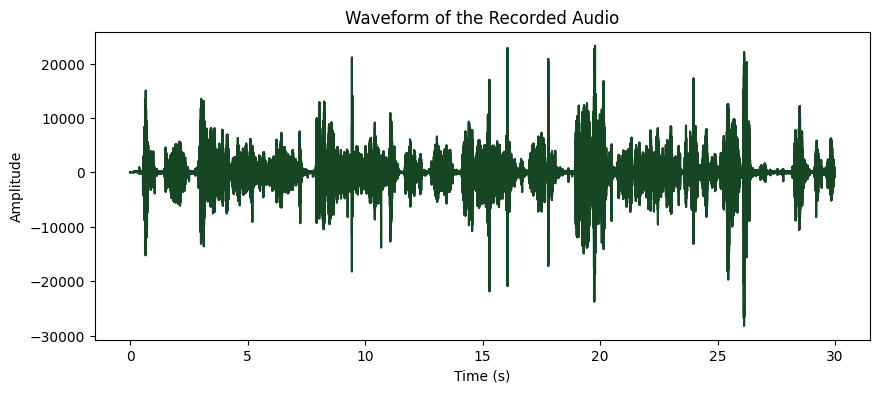

In [5]:
plot_waveform("testing.wav")

### Option 2: User-Uploaded Files

Sample Rate: 44100
Audio Data: [ 0.000000e+00  0.000000e+00  0.000000e+00 ... -9.304419e-14 -9.690668e-14
 -8.942789e-14]


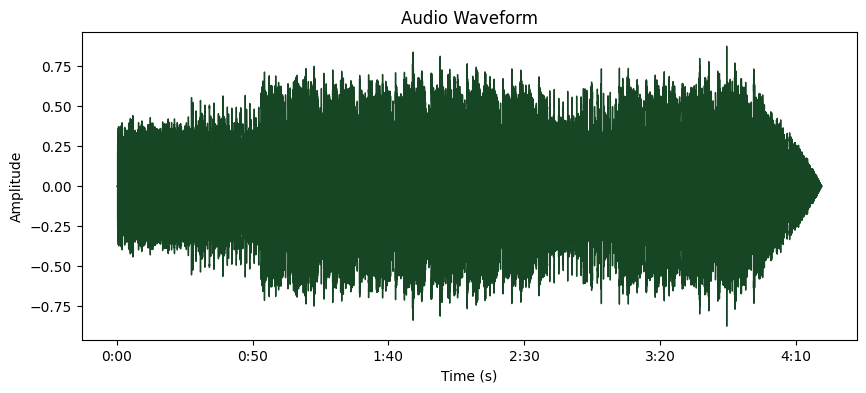

In [6]:
# use librosa for audio files, whereas pyaudio is used for real-time audio streams
test_audio = 'C:\\Users\\adith\\OneDrive\\Desktop\\vs code xoxo\\personal\\Oracle\\oracle_venv\\fresh-clone\\california_world.mp3'

#load in the file: 

audio_data, sample_rate = librosa.load(test_audio, sr=None)

#print to check: 

print(f'Sample Rate: {sample_rate}')
print(f'Audio Data: {audio_data}')


#plot waveform for funzies: 

plt.figure(figsize=(10,4))
librosa.display.waveshow(audio_data, sr=sample_rate, color='#164624')
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

### Feature Extraction for the Uploaded Waveform

MFCCs: 
- a representation of short-term power spectrum of a sound 
- based on a linear cosine transform of a log of the power spectrum on a non-linear mel scale
- commonly used in speech & audio processing tasks 
- can recognize emotions in a speaker's voice and classify music into genres 

Chroma Features: 
- chroma features represent the 12 different pitch classes of a musical octave 
- really good at picking up slight changes in timbre & instrumentation 
- used in music retrieval tasks like chord recognition & key detection 
- a way to represent the tonal context of a musical audio signal in a condensed form 

Spectral Contrast: 
- measures the difference in amplitude between peaks and valleys in a sound spectrum 
- captures the relative distribution of energy across the frequency spectrum and is useful for distinguishing between different types of sounds such as speech and music

Tonnetz: 
- represent the harmonic & melodic components of music 
- captures relationships between pitches and is also useful for key detection and chord recognition

Mel-Scaled Spectrogram: 
- a spectrogram where the frequencies are scaled according the mel scale, which approximates the human ear's perception of sound 
- useful for visualizing the frequencies within an audio signal in a way that lines up with the way our ears would hear it 

In [7]:
import librosa

# reload the audio file so following code blocks can execute the && jupyter notebooks doesn't get confused
audio_path = 'C:\\Users\\adith\\OneDrive\\Desktop\\vs code xoxo\\personal\\Oracle\\oracle_venv\\fresh-clone\\california_world.mp3'
# y is the "test audio" that we had previously
y, sr = librosa.load(audio_path, sr = 22050)

In [8]:
#step 1: Extract features:

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

In [9]:
#step 2: Combine features: 

mfccs_mean = np.mean(mfccs, axis=1)
chroma_mean = np.mean(chroma, axis=1)
spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
tonnetz_mean = np.mean(tonnetz, axis=1)

In [10]:
#step 3: Combine into a single feature vector
feature_vector = np.hstack([mfccs_mean, chroma_mean, spectral_contrast_mean, tonnetz_mean])

In [11]:
#optional: print out the vector to see it for funzies
print(feature_vector)

[-1.19439873e+02  1.15534729e+02  9.10197639e+00  1.58807144e+01
  3.06296539e+00 -3.86641264e+00 -1.14549771e-01  8.58955669e+00
  6.71586752e+00  7.82180738e+00  1.80883145e+00  1.00113688e+01
  2.48616624e+00  2.90449053e-01  2.47736588e-01  3.50238234e-01
  2.78483152e-01  2.96141565e-01  5.02131581e-01  3.39676291e-01
  6.43634260e-01  3.14863056e-01  3.71400386e-01  5.44088900e-01
  3.48741293e-01  1.98347736e+01  1.44098433e+01  2.00197972e+01
  1.92636745e+01  1.83383434e+01  1.72727062e+01  4.70841222e+01
 -1.03588220e-01  1.89049989e-01  9.64397717e-02  1.87047864e-02
  4.52142891e-02  5.08466687e-02]


### Train a Model & Stuff

In [12]:
csv_file_path = "C:\\Users\\adith\OneDrive\\Desktop\\vs code xoxo\\personal\\Oracle\\oracle_venv\\fresh-clone\\GTZANdownload\Data\\features_30_sec.csv"
data = pd.read_csv(csv_file_path)

print(data.head())

          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\adith\AppData\Local\Temp\ipykernel_26796\2367577167.py:1: SyntaxWarning: invalid escape sequence '\O'
  csv_file_path = "C:\\Users\\adith\OneDrive\\Desktop\\vs code xoxo\\personal\\Oracle\\oracle_venv\\fresh-clone\\GTZANdownload\Data\\features_30_sec.csv"


In [13]:
selected_features = ['mfcc1_mean', 'mfcc2_mean', 'chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'tempo', 'label']

# Create a new DataFrame with only the selected features
data_selected = data[selected_features]

# Display the first few rows of the selected data
print(data_selected.head())

   mfcc1_mean  mfcc2_mean  chroma_stft_mean  rms_mean  spectral_centroid_mean  \
0 -113.570648  121.571793          0.350088  0.130228             1784.165850   
1 -207.501694  123.991264          0.340914  0.095948             1530.176679   
2  -90.722595  140.446304          0.363637  0.175570             1552.811865   
3 -199.544205  150.090897          0.404785  0.141093             1070.106615   
4 -160.337708  126.219635          0.308526  0.091529             1835.004266   

        tempo  label  
0  123.046875  blues  
1   67.999589  blues  
2  161.499023  blues  
3   63.024009  blues  
4  135.999178  blues  


In [14]:
# Separate features (X) and labels (y)
X = data_selected.drop('label', axis=1)  # Features
y = data_selected['label']  # Labels

# Encode the labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the selected features
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.49
Classification Report:
              precision    recall  f1-score   support

       blues       0.39      0.45      0.42        20
   classical       0.69      0.85      0.76        13
     country       0.44      0.30      0.36        27
       disco       0.61      0.52      0.56        21
      hiphop       0.38      0.40      0.39        15
        jazz       0.62      0.68      0.65        22
       metal       0.61      0.88      0.72        25
         pop       0.36      0.38      0.37        13
      reggae       0.47      0.30      0.37        23
        rock       0.25      0.24      0.24        21

    accuracy                           0.49       200
   macro avg       0.48      0.50      0.48       200
weighted avg       0.48      0.49      0.48       200

Confusion Matrix:
[[ 9  1  2  2  1  0  1  1  1  2]
 [ 0 11  0  0  0  2  0  0  0  0]
 [ 6  1  8  0  0  2  0  2  1  7]
 [ 0  0  0 11  1  0  6  1  0  2]
 [ 0  0  0  0  6  0  2  4  3  0]
 [ 1  3  0  0  0 15 

In [17]:
def extract_selected_features(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, duration=30)
    
    # Chroma STFT mean
    chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)).item()
    
    # RMS mean
    rms_mean = np.mean(librosa.feature.rms(y=y)).item()
    
    # Spectral Centroid mean
    spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)).item()
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo = float(tempo)
    
    # MFCCs (Extracting first two MFCCs and calculating their means)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=2)  # Specify 2 to extract only the first two MFCCs
    mfcc1_mean = np.mean(mfccs[0, :]).item()  # Mean of the first MFCC
    mfcc2_mean = np.mean(mfccs[1, :]).item()  # Mean of the second MFCC
    
    # Return the features as a numpy array
    return np.array([chroma_stft_mean, rms_mean, spectral_centroid_mean, tempo, mfcc1_mean, mfcc2_mean])

def predict_genre(audio_file_path, model, label_encoder, scaler):
    # Extract features from the new audio file
    features = extract_selected_features(audio_file_path)
    
    # Scale the features
    features_scaled = scaler.transform([features])
    
    # Predict genre
    prediction = model.predict(features_scaled)
    predicted_genre = label_encoder.inverse_transform(prediction)
    
    return predicted_genre

# Example usage
audio_file_path = audio_path  # Path to the new audio file
predicted_genre = predict_genre(audio_file_path, rf_classifier, label_encoder, scaler)
print(f'The predicted genre is: {predicted_genre[0]}')


The predicted genre is: metal


C:\Users\adith\AppData\Local\Temp\ipykernel_26796\3595023527.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(tempo)
c:\Users\adith\OneDrive\Desktop\vs code xoxo\personal\Oracle\oracle_venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Connect to Spotify's API ###

In [ ]:
load_dotenv()

#print('hello world')

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

print(client_id, client_secret)

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content.decode('utf-8'))
    token = json_result["access_token"]
    return token


def get_auth_header(token):
    return {"Authorization" : "Bearer " + token}

#search an artist:
def search_for_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    #construct a query:
    query = f"?q={artist_name}&type=artist&limit=1" #limit = 1 means only 1 result/ most popular

    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)["artists"]["items"]
    if len(json_result) == 0:
        print("No artist with this name exists...")
        return None

    return json_result[0]
    #print(json_result)


def get_songs_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=US"
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)["tracks"]
    return json_result


token = get_token()
#print(token)
result = search_for_artist(token, "ACDC")
artist_id = result["id"]
songs = get_songs_by_artist(token, artist_id)

for idx, song in enumerate(songs):
    print(f"{idx + 1}. {song['name']}")